Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [22]:
NAME = "Irina Nagaeva"
COLLABORATORS = "BPM184"

---

# Метод наименьших квадратов (линейный случай).

Рассмотрим функцию $y = f(x)$ определенной набором значений $y_0, y_1, \cdots, y_n$ в точках $x_0, x_1, \cdots, x_n$.

In [23]:
import numpy as np

x = np.asarray([-1, -0.7, -0.43, -0.14, 0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.asarray([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

rng = np.random.default_rng(123)
x += 0.1 * rng.uniform(size=len(x))
y += 4 * rng.uniform(size=len(x))

AttributeError: module 'numpy.random' has no attribute 'default_rng'

### I. Найдите многочлен наилучшего приближения,

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

используя линейный метод наименьших квадратов.Для этого:

1. реализуйте алгоритм, создающий  "design matrix" `А`, используя $1, x, \cdots, x^m$ в качестве базисных функций.

2. постройте явно нормальную систему уравнений задачи наименьших квадратов при фиксированных значениях $m$.

3. решите систему уравнений, чтобы найти коэффициенты $P_m(x)$ для $m = 0, 1, 2, \dots$. Для решения задач линейной алгебры можете использовать либо библиотечные функции (`numpy.linalg.solve`), либо Вашу реализацию LU - разложение из 1 недели.

In [24]:
import numpy as np

def design_matrix(x, m):
    """Construct the design matrix with monomials x**k for k=0..m-1"""
    A = np.ones((len(x),m))
    
    for k in range(1, m):
      A[:, k] = np.multiply(A[:,k-1],x)
    
    return A

In [25]:
assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

In [26]:
def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
    
    a = design_matrix(x, m)
    beta = np.linalg.solve(np.transpose(a) @ a, np.transpose(a) @ y)

    return np.polynomial.Polynomial(beta)

In [27]:
import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

Вычислите число обусловленности матрицы `A` и матрицы левой части системы нормальных уравнений в зависимости $m$, и напечатайте их на экран.
Прокомментируйте полученные результаты.

In [28]:
for m in range(1, 10):
    A = design_matrix(x, m)
    AT_A = np.transpose(A) @ A
    print(np.linalg.cond(A), np.linalg.cond(AT_A)) #решение системы плохое, так как возрастает ошибка при больших кондах

1.0 1.0
2.447615420440157 5.990821246376438
7.483129195570694 55.99722255760249
29.861852513689726 891.7302355493313
128.47106209496448 16504.81379580696
593.5483304236662 352299.6205485101
2898.458675569127 8401062.694032481
14877.4809877738 221339440.6045199
80008.98556716973 6401437738.2670145


In [29]:
# This cell is a test: keep it intact


### II. Многочлен наилучшего приближения.

Ясно, что бесконтрольно увеличивать степень аппроксимирующего многочлена довольно бессмысленно. Зададимся целью построить "оптимальный" многочлен как можно более низкой степени $m$.

Для нахождения оптимального значения $m$ используйте следующий критерий: возьмем $m = 1, 2, \dots$, и для каждого значения $m$ вычислим

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

и возьмем такое значение $m$, при котором $\sigma_m$ стабилизируется или начинает расти.

In [30]:
def sigma(x, y, m):
    r"""Compute $\sigma_m$."""
    A = design_matrix(x, m)
    beta = np.linalg.solve(np.transpose(A)@A, np.transpose(A) @ y)
    p = np.polynomial.Polynomial(beta)
    sum = 0.
    for i in range(len(x)):
        sum += (p(x[i]) - y[i])**2
    t = 1./(len(x)-m)
    return sum * t

In [31]:
for m in range(1, 15):
    print(m, sigma(x, y, m))

1 8.03076380952381
2 4.708387914514461
3 2.7104781521019907
4 0.015809710949731937
5 0.016467784096566053
6 0.015742856246826684
7 0.014180344063844783
8 0.01471987376528063
9 0.016290760744330182
10 0.019537554997222022
11 0.021148910762757864
12 0.0260001733681141
13 0.01748707085070091
14 0.01177025874230244


Постройте ваши полиномы $P_m(x)$ вместе с данными. Визуально сравните полиномы различных степеней. Согласуется ли визуальное сравнение с ожидаемым оптимальным значением $m$?

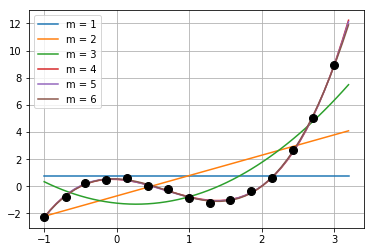

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for m in range(1, 7):
    p = lsq_poly(x, y, m)
    
    xx = np.linspace(-1, 3.2, 51)
    ax.plot(xx, p(xx), '-', label='m = %s' % m)

ax.plot(x, y, 'o', ms=8, color='k')
plt.legend(loc='best')
plt.grid()

### III. МНК с использованием QR-разложения.

Для оптимального значения $m$ из предыдущей части решите задачу МНК, QR-разложение design матрицы. Для решения задач линейной алгебры можете использовать библиотечные функции (обратите внимание на `scipy.linalg.solve_triangular` и `scipy.linalg.qr` и т.д.) или код предыдущих недель.
Сравните результат с ответом, полученным при решении системы уравнений.

In [33]:
def lsq_qr(x, y, m):
    from scipy.linalg import solve_triangular
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    A = design_matrix(x, m)
    Q, R = np.linalg.qr(A)
    g = np.transpose(Q)@y
    
    beta = solve_triangular(R[0:m,:],g[0:m])
    p = np.polynomial.Polynomial(beta)
    return p

In [34]:
from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

In [35]:
# This cell spot-tests several polynomials to make sure that they are worse than your ``best'' polynomial.

